In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("/content/OnlineRetail.csv")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [5]:
df.shape

(24721, 8)

In [6]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,111
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,8691
Country,0


# **Cleaning**

In [8]:
df = df.dropna(subset=['CustomerID'])

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# **Top Countries by Revenue**

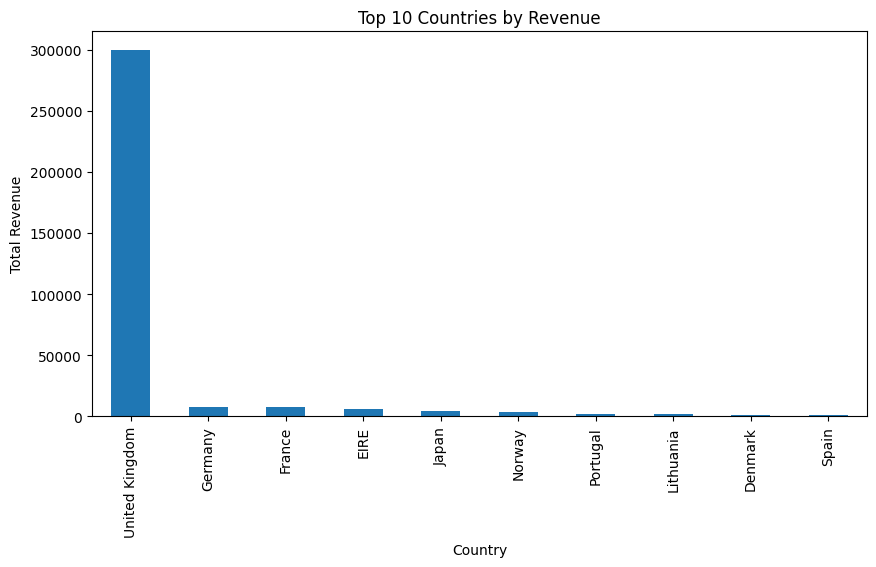

In [9]:
top_countries = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_countries.plot(
    kind='bar',
    title='Top 10 Countries by Revenue',
    figsize=(10,5))
plt.ylabel("Total Revenue")
plt.show()

# **Top Selling Products by Quantity**

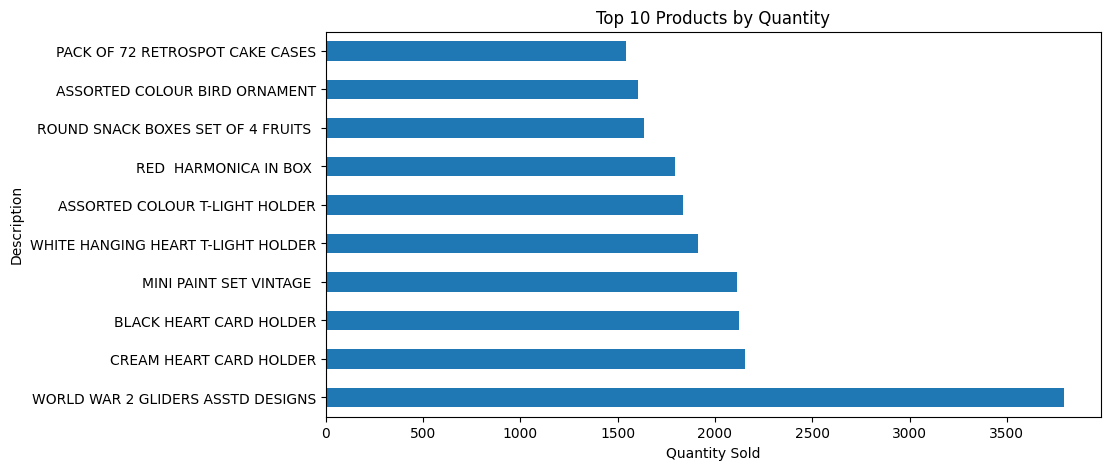

In [10]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(
    kind='barh',
    title='Top 10 Products by Quantity',
    figsize=(10,5))
plt.xlabel("Quantity Sold")
plt.show()

# **Distribution of UnitPrice**

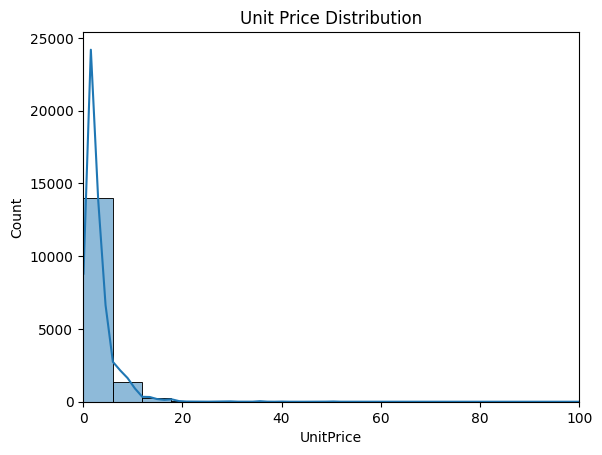

In [12]:
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.xlim(0, 100)
plt.title("Unit Price Distribution")
plt.show()

# **Select Features for Clustering**

In [13]:
features = df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()

features.columns = ['CutomerID', 'TotalQuantity', 'TotalSpent', 'NumPurchases']
features.head()

,CutomerID,TotalQuantity,TotalSpent,NumPurchases
0,12347.0,319,711.79,1
1,12386.0,214,258.90,1
2,12395.0,528,346.10,1
3,12427.0,79,303.50,1
4,12429.0,454,1281.50,1


# **Feature Scaling**

In [14]:
X = features[['TotalQuantity', 'TotalSpent', 'NumPurchases']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Determine Optimal Number of Clusters (Elbow + Silhouette)**

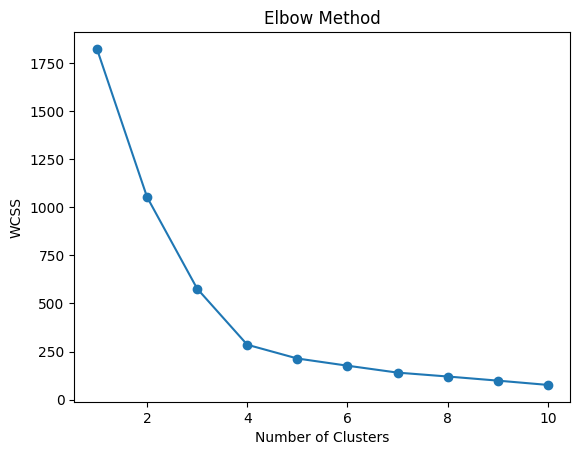

In [15]:
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# **Silhouette Score**

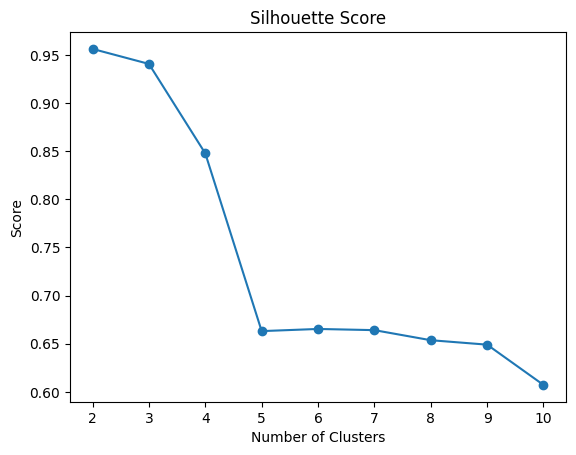

In [16]:
sil = []
for k in range(2,11):
  kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
  labels = kmeans.fit_predict(X_scaled)
  sil.append(silhouette_score(X_scaled, labels))

plt.plot(range(2, 11), sil, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [17]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [19]:
features['Cluster'] = kmeans.labels_

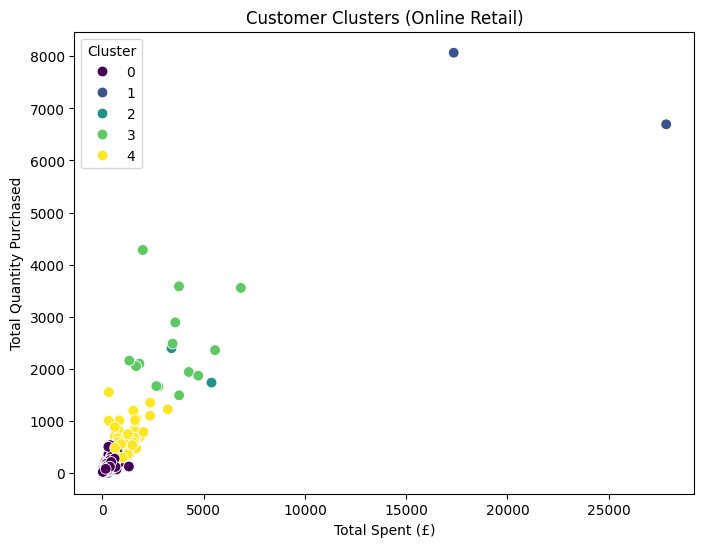

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=features, x='TotalSpent', y='TotalQuantity', hue='Cluster', palette='viridis', s=60)
plt.title('Customer Clusters (Online Retail)')
plt.xlabel('Total Spent (£)')
plt.ylabel('Total Quantity Purchased')
plt.legend(title='Cluster')
plt.show()

In [21]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Create DataFrame for centroids
centroids_df = pd.DataFrame(centroids, columns=['TotalQuantity', 'TotalSpent', 'NumPurchases'])
centroids_df['Cluster'] = centroids_df.index

# Show centroids
print(centroids_df)

   TotalQuantity    TotalSpent  NumPurchases  Cluster
0     142.901163    293.696725      1.104651        0
1    7382.500000  22589.695000      7.500000        1
2    2062.500000   4404.770000     28.500000        2
3    2432.285714   3454.032143      2.857143        3
4     585.837838   1137.133378      2.135135        4
